In [4]:
"""News Aggregator Datasetでの文書分類モデルの実装"""

!wget https: // archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip


--2022-08-02 08:48:59--  ftp://https/
           => `.listing'
https (https) をDNSに問いあわせています... 失敗しました: 名前またはサービスが不明です.
wget: ホストアドレス `https' を解決できませんでした。
//: スキームがありません.
--2022-08-02 08:48:59--  http://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
archive.ics.uci.edu (archive.ics.uci.edu) をDNSに問いあわせています... 128.195.10.252
archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 29224203 (28M) [application/x-httpd-php]
`NewsAggregatorDataset.zip' に保存中

NewsAggregatorDatas 100%[===================>]  27.87M  1.26MB/s    in 22s     

2022-08-02 08:49:23 (1.25 MB/s) - `NewsAggregatorDataset.zip' へ保存完了 [29224203/29224203]

終了しました --2022-08-02 08:49:23--
経過時間: 24s
ダウンロード完了: 1 ファイル、28M バイトを 22s で取得 (1.25 MB/s)
Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inf

In [5]:
# 先頭10行の確認
!head - 10 ./newsCorpora.csv


==> 標準入力 <==
^C


In [6]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=[
                 'ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
# データの抽出 (TITLEとCATEGORYだけ使う)
df = df.loc[df['PUBLISHER'].isin(
    ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=123, stratify=df["CATEGORY"])
valid, test = train_test_split(
    valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


In [8]:
train


,TITLE,CATEGORY
0,REFILE-UPDATE 1-European car sales up for sixt...,b
1,Amazon Plans to Fight FTC Over Mobile-App Purc...,t
2,Kids Still Get Codeine In Emergency Rooms Desp...,m
3,What On Earth Happened Between Solange And Jay...,e
4,NATO Missile Defense Is Flight Tested Over Hawaii,b
...,...,...
10679,The Pillow Book of Tim Geithner,b
10680,Robin Thicke spends $20000 on Amethyst stone a...,e
10681,Japanese Shares Little Changed After Biggest R...,b
10682,WRAPUP 1-Liberia shuts schools as Ebola spread...,m


In [9]:
train["CATEGORY"].value_counts()


b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64

In [10]:
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt


/home/kontani0930/.pyenv/versions/3.9.6/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Datasetの定義(PyTorchで使われる、特徴ベクトルとラベルベクトルを合わせて保持するクラス)
class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        #指定した最長系列長までパディングした上で単語IDに変換する
        inputs = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len, pad_to_max_length=True,
        )
        ids=inputs["input_ids"]
        mask=inputs["attention_mask"]

        return {
            "ids":torch.LongTensor(ids),
            "mask":torch.LongTensor(mask),
            "labels":torch.Tensor(self.y[index])
        }

In [20]:
#正解ラベルのone-hot化
y_train=pd.get_dummies(train,columns=["CATEGORY"])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

#Datasetの作成
max_len=20
#BERTの英語版事前学習済みモデルのうち、手軽に試せるUncased(小文字のみに対応)を使っていく
tokenizer =BertTokenizer.from_pretrained("bert-base-uncased")
dataset_train=CreateDataset(X=train["TITLE"],y=y_train,tokenizer=tokenizer,max_len=max_len)
dataset_valid=CreateDataset(X=valid["TITLE"],y=y_valid,tokenizer=tokenizer,max_len=max_len)
dataset_test=CreateDataset(X=test["TITLE"],y=y_test,tokenizer=tokenizer,max_len=max_len)

for var in dataset_train[0]:
    #入力文字列がidsとしてID系列に変換されていることが確認できる。
    #BERTでは文頭と文末の特殊区切り文字[CLS]と[SEP]が101,102として系列に含まれる。0はパディングである。
    print(f'{var}: {dataset_train[0][var]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([  101, 25416,  9463,  1011, 10651,  1015,  1011,  2647,  2482,  4341,
         2039,  2005,  4369,  3204,  2004, 18730,  8980,   102,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
labels: tensor([1., 0., 0., 0.])


/home/kontani0930/.pyenv/versions/3.9.6/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
y_train

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]], dtype=uint8)

In [22]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, output_size):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased",return_dict=False)
        self.drop = torch.nn.Dropout(drop_rate)
        # 全結合層 BERTの出力に合わせて768次元を指定
        self.fc = torch.nn.Linear(768, output_size)

    def forward(self, ids, mask):
        _, out = self.bert(ids, attention_mask=mask)
        out = self.fc(self.drop(out))
        return out

In [23]:
#BERT分類モデルの学習
def calculate_loss_and_accuracy(model,criterion,loader,device):
    #損失・正解率を計算
    model.eval()
    loss,total,correct=0.0,0,0

    with torch.no_grad():
        for data in loader:
            #デバイスの指定
            ids=data["ids"].to(device)
            mask=data["mask"].to(device)
            labels=data["labels"].to(device)

            #順伝播
            outputs=model(ids,mask)

            #損失計算
            loss+=criterion(outputs,labels).item()

            #正解率計算
            pred=torch.argmax(outputs,dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
            labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
            total+=len(labels)
            correct+=(pred==labels).sum().item()
    
    return loss/len(loader),correct/total

In [24]:
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
    # モデルの学習を実行し、損失・正解率のログを返す
    # デバイスの指定
    model.to(device)

    # dataloaderの作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size,shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    # 学習
    log_train, log_valid = [], []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for data in dataloader_train:
            # デバイスの指定
            ids = data["ids"].to(device)
            mask = data["mask"].to(device)
            labels = data["labels"].to(device)

            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # 順伝播+誤差逆伝播+重み更新
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(
            model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy(
            model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        #torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoints/checkpoint{epoch + 1}.pt')
        torch.save(model.state_dict(), f'checkpoints/checkpoint{epoch + 1}.pt')

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')
    return {"train": log_train, "valid": log_valid}


In [25]:
!mkdir -vp checkpoints

In [26]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 8
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 1, loss_train: 0.0829, accuracy_train: 0.9542, loss_valid: 0.1084, accuracy_valid: 0.9296, 48.2278sec
epoch: 2, loss_train: 0.0440, accuracy_train: 0.9782, loss_valid: 0.0992, accuracy_valid: 0.9341, 51.8965sec
epoch: 3, loss_train: 0.0338, accuracy_train: 0.9811, loss_valid: 0.1091, accuracy_valid: 0.9192, 54.2707sec
epoch: 4, loss_train: 0.0177, accuracy_train: 0.9929, loss_valid: 0.1087, accuracy_valid: 0.9296, 54.2198sec
epoch: 5, loss_train: 0.0139, accuracy_train: 0.9939, loss_valid: 0.1241, accuracy_valid: 0.9251, 53.8267sec
epoch: 6, loss_train: 0.0108, accuracy_train: 0.9960, loss_valid: 0.1230, accuracy_valid: 0.9334, 53.0363sec
epoch: 7, loss_train: 0.0109, accuracy_train: 0.9950, loss_valid: 0.1402, accuracy_valid: 0.9207, 52.7218sec
epoch: 8, loss_train: 0.0067, accuracy_train: 0.9975, loss_valid: 0.1289, accuracy_valid: 0.9289, 52.3779sec


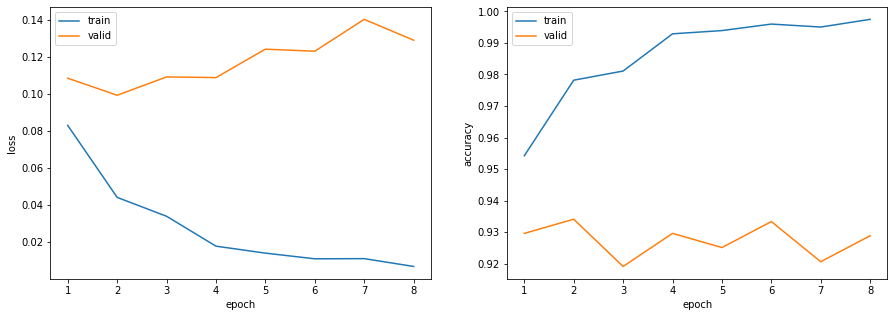

In [27]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [28]:
# 正解率の算出
def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

model=model.load_state_dict(torch.load("checkpoints/checkpoint8.pt"))
print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

AttributeError: '_IncompatibleKeys' object has no attribute 'eval'